In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
dataset = tfds.load('imdb_reviews', as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']

batch_size = 32
train_dataset = train_dataset.shuffle(10000)
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.BBNGGP_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.BBNGGP_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.BBNGGP_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
example, label = next(iter(train_dataset))
print('Text:\n', example.numpy()[0])
print('\nLabel: ', label.numpy()[0])

Text:
 b'I loved the first season. The quality went down a little bit in the second season, which however had a great middle (Pegasus!). Third season was fairly novel and original and was OK. Fourth season started going downhill fast, because they never even began giving us any explanations, when by now we were really starting to need them. What the hell was the Cylon plan? Why were there two Cylon factions? What was the point of Angel-Kara leading the fleet to a devastated Earth-1? What kind of a past did the last five Cylons have, and how did they survive, or were they reincarnations? Questions everywhere, answers nowhere.<br /><br />And then comes the end. Earth-2 (our Earth) in the past. Well, okay. But destroying the fleet?! Giving up technology and giving up any kind of urban life, and spreading a few thousand people paper-thinly across the planet?! That\'s not only anti-science, it\'s anti-reason and anti-life. And the philosophy of the show then seems to be that humanity is for

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=10000)
encoder.adapt(train_dataset.map(lambda text, _: text))

vocabulary = np.array(encoder.get_vocabulary())

original_text = example.numpy()[0]
encoded_text = encoder(original_text).numpy()
decoded_text = ' '.join(vocabulary[encoded_text])

print('original: ', original_text)
print('encoded: ', encoded_text)
print('decoded: ', decoded_text)

original:  b'I loved the first season. The quality went down a little bit in the second season, which however had a great middle (Pegasus!). Third season was fairly novel and original and was OK. Fourth season started going downhill fast, because they never even began giving us any explanations, when by now we were really starting to need them. What the hell was the Cylon plan? Why were there two Cylon factions? What was the point of Angel-Kara leading the fleet to a devastated Earth-1? What kind of a past did the last five Cylons have, and how did they survive, or were they reincarnations? Questions everywhere, answers nowhere.<br /><br />And then comes the end. Earth-2 (our Earth) in the past. Well, okay. But destroying the fleet?! Giving up technology and giving up any kind of urban life, and spreading a few thousand people paper-thinly across the planet?! That\'s not only anti-science, it\'s anti-reason and anti-life. And the philosophy of the show then seems to be that humanity is

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(1,), dtype=tf.string),
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 64)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 128)      │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 751,489 (2.87 MB)

 Trainable params: 751,489 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=test_dataset,
)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1087s 1s/step - accuracy: 0.6834 - loss: 0.5606 - val_accuracy: 0.8251 - val_loss: 0.3784
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1088s 1s/step - accuracy: 0.8716 - loss: 0.2972 - val_accuracy: 0.8638 - val_loss: 0.3560
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1105s 1s/step - accuracy: 0.9143 - loss: 0.2128 - val_accuracy: 0.7802 - val_loss: 0.4292
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1096s 1s/step - accuracy: 0.9176 - loss: 0.2021 - val_accuracy: 0.8566 - val_loss: 0.3462
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1117s 1s/step - accuracy: 0.9528 - loss: 0.1263 - val_accuracy: 0.8563 - val_loss: 0.3778


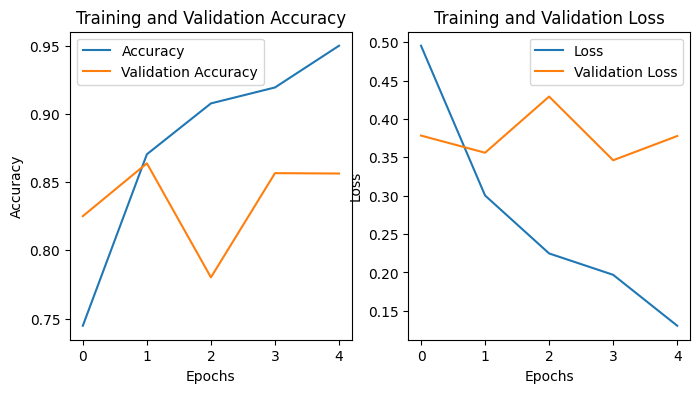

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()

In [ ]:
sample_text = (
    '''The movie by GeeksforGeeks was so good and the animation are so dope.
    I would recommend my friends to watch it.'''
)
sample_text_tensor = tf.constant([sample_text], dtype=tf.string)

predictions = model.predict(sample_text_tensor)

print("Prediction probability:", predictions[0])

if predictions[0] > 0.5:
    print('The review is positive')
else:
    print('The review is negative')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
Prediction probability: [2.2979064]
The review is positive
